In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Imports

In [2]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long  - 5 minutes!!!
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
df_single_gal1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i1)+'.parquet')
df_single_gal2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)
df_single = pd.concat([df_single_ps1, df_single_ps2, df_single_gal1, df_single_gal2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
df_single_gal1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_flux_'+str(i1)+'.parquet')
df_single_gal2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)
df_single_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux, df_single_gal1_flux, df_single_gal2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')

df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

# Apply the filter to the dataframe
all_obj = df_single[
    (df_single['ra'] >= ra_min) & (df_single['ra'] <= ra_max) &
    (df_single['dec'] >= dec_min) & (df_single['dec'] <= dec_max)]


In [93]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)

def estimate_purity_completness(df_obj, tru_obj, match_value = 1):
    """Estimate the purity and completness of the detected objects
    
        Parameters
    ----------
    obj4_field : `pd.dataframe`
        Detected objects
    tru_obj : `pd.dataframe`
        True variable objects
    match_value : `float`
        matching radius in arcsec    
    
    Returns
    -------
    purity, completeness  : `float`, `float`
        Purity and completness
    """

    # all of the diaObjects in a field
    dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
    # all of the variable objects in a field
    tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
    # match the observations to the truth
    idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
    # index of all diaObj that are within match_value of a true variable object
    idx_close = idx[d2d.to(u.arcsec).value<match_value]

    # all of diaObjects thare are within match_value of a variable object
    matches_close = df_obj.iloc[idx_close]

    # fraction of dia Objects that are actually near a variable objects 
    purity = len(matches_close)/len(df_obj)

    # fraction of variable objects that have been detected 
    completnes = len(matches_close)/len(tru_obj_SC)

    return purity, completnes

def plotFlagImages(exp, flagList=['DETECTED_NEGATIVE', 'DETECTED', 'SENSOR_EDGE', 'INEXACT_PSF']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im


In [4]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'

############################################
pp_collections_1 = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
schema_1 =  f'pp_ppdb_lsstcomcamsim_or4'

pp_collections_2 = 'u/sullii/DM-46333/OR4/association'
schema_2 = 'pp_ppdb_dm46333F2'

pp_collections_3 = 'u/sullii/DM-46333/OR4/databaseTimeoutFix_with_forcedSourceLimit'
schema_3 = f'jeremym_ppdb_replication_test_3'
############################################


pp_collections = pp_collections_3
schema = schema_3

butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [5]:
ra_min = 215.6
ra_max = 216.4
dec_min = -12.9
dec_max = -12.15

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value

In [6]:
columns = [
    "diaSourceId", 
    "diaObjectId", 
    "ra", 
    "dec", 
    "raErr", 
    "decErr", 
    "midpointMjdTai", 
    "psfFlux", 
    "psfFluxErr", 
    "scienceFlux", 
    "scienceFluxErr", 
    "snr", 
    "band", 
    "visit",
    "detector",    
    "x",
    "xErr",
    "y",
    "yErr",
    "time_processed", 
    "time_withdrawn",
    "isDipole",
    "centroid_flag",
    "apFlux_flag",
    "apFlux_flag_apertureTruncated",
    "psfFlux_flag",
    "psfFlux_flag_edge",
    "psfFlux_flag_noGoodPixels",
    "trail_flag_edge",
    "forced_PsfFlux_flag",
    "forced_PsfFlux_flag_edge",
    "forced_PsfFlux_flag_noGoodPixels",
    "shape_flag",
    "shape_flag_no_pixels",
    "shape_flag_not_contained",
    "shape_flag_parent_source",
    "pixelFlags",
    "pixelFlags_bad",
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "pixelFlags_edge",
    "pixelFlags_interpolated",
    "pixelFlags_interpolatedCenter",
    "pixelFlags_offimage",
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_injected",
    "pixelFlags_injectedCenter",
    "pixelFlags_injected_template",
    "pixelFlags_injected_templateCenter",
    "reliability"
]

# Convert list of columns into a comma-separated string
columns_string = ', '.join(f'"{col}"' for col in columns)

# Then use this in your SQL query
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            {columns_string}
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [7]:
#latest = False does not work

apdbQuery_3 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_3)
or4_obj_3 = apdbQuery_3.load_objects(limit=1e7, latest=True)

apdbQuery_2 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_2)
or4_obj_2 = apdbQuery_2.load_objects(limit=1e7, latest=True)

apdbQuery_1 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_1)
or4_obj_1 = apdbQuery_1.load_objects(limit=1e7, latest=True)


In [8]:
# lets look at only one field
# objects
obj4_1_field = or4_obj_1[(or4_obj_1['ra'] > ra_min) & (or4_obj_1['ra'] < ra_max) & (or4_obj_1['dec'] > dec_min) & (or4_obj_1['dec'] < dec_max)]
obj4_2_field = or4_obj_2[(or4_obj_2['ra'] > ra_min) & (or4_obj_2['ra'] < ra_max) & (or4_obj_2['dec'] > dec_min) & (or4_obj_2['dec'] < dec_max)]
obj4_3_field = or4_obj_3[(or4_obj_3['ra'] > ra_min) & (or4_obj_3['ra'] < ra_max) & (or4_obj_3['dec'] > dec_min) & (or4_obj_3['dec'] < dec_max)]

# src4_1_field = src4_1_field[(or4_src_1['ra'] > ra_min) & (or4_src_1['ra'] < ra_max) & (or4_src_1['dec'] > dec_min) & (or4_src_1['dec'] < dec_max)]
# src4_2_field = src4_1_field[(or4_src_2['ra'] > ra_min) & (or4_src_2['ra'] < ra_max) & (or4_src_2['dec'] > dec_min) & (or4_src_2['dec'] < dec_max)]
src4_3_field = src4_field[(src4_field['ra'] > ra_min) & (src4_field['ra'] < ra_max) & (src4_field['dec'] > dec_min) & (src4_field['dec'] < dec_max)]


In [9]:
# latest rerun
print(estimate_purity_completness(obj4_1_field, tru_var_obj))
print(estimate_purity_completness(obj4_2_field, tru_var_obj))
print(estimate_purity_completness(obj4_3_field, tru_var_obj))

tru_var_obj_bright = tru_var_obj[tru_var_obj['magnorm'] < 22.32]
print('**********')

print(estimate_purity_completness(obj4_1_field, tru_var_obj_bright))
print(estimate_purity_completness(obj4_2_field, tru_var_obj_bright))
print(estimate_purity_completness(obj4_3_field, tru_var_obj_bright))

(0.07624220478776907, 0.4275239706711788)
(0.183125, 0.1652566271855612)
(0.06970293486041518, 0.43936830231246476)
**********
(0.040032186682760006, 0.9590361445783132)
(0.1375, 0.5301204819277109)
(0.03561202576950608, 0.9590361445783132)


In [10]:
def flux_to_magnitude_src(df_single_flux_src):
    """
    Converts scienceFlux to magnitude based on the band specified in the 'band' column.
    
    Args:
        df_single_flux_src (pd.DataFrame): DataFrame containing 'scienceFlux' and 'band' columns.
    
    Returns:
        pd.DataFrame: DataFrame with an added 'magnitude' column.
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Function to calculate magnitude from flux for a specific band
    def calculate_magnitude(row):
        band = row['band']
        flux = row['scienceFlux']
        
        # Get the zeropoint for the band, if band is in zeropoints
        if band in zeropoints:
            zp = zeropoints[band]
            # Handle zero or negative flux to avoid invalid log10 operations
            if flux > 0:
                return zp - 2.5 * np.log10(flux)
            else:
                return np.nan  # Return NaN for zero or negative flux values
        else:
            return np.nan  # Return NaN if the band is not found
    
    # Apply the magnitude calculation function to each row
    df_single_flux_src['magnitude'] = df_single_flux_src.apply(calculate_magnitude, axis=1)
    
    # Return the modified DataFrame
    return df_single_flux_src

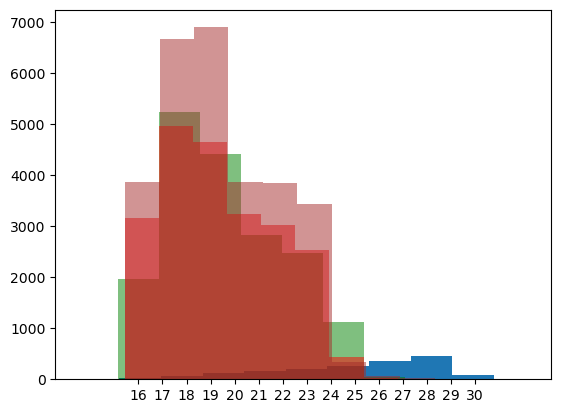

In [11]:
# Filter the dataframe to only include rows where the 'band' column is 'g'
g_band_rows = src4_field[src4_field['band'] == 'g']

# Now apply the create_mag_errors function only to the filtered rows
mag_errors_g_band = create_mag_errors(g_band_rows['scienceFlux'], g_band_rows['scienceFluxErr'])[0]

# Filter for 'r' band
r_band_rows = src4_field[src4_field['band'] == 'r']
# Apply the create_mag_errors function to the filtered rows for 'r' band
mag_errors_r_band = create_mag_errors(r_band_rows['scienceFlux'], r_band_rows['scienceFluxErr'])[0]

# Filter for 'i' band
i_band_rows = src4_field[src4_field['band'] == 'i']
# Apply the create_mag_errors function to the filtered rows for 'i' band
mag_errors_i_band = create_mag_errors(i_band_rows['scienceFlux'], i_band_rows['scienceFluxErr'])[0]

plt.hist(tru_var_obj['magnorm'])
plt.hist(mag_errors_g_band, alpha=0.5, color='g')
plt.hist(mag_errors_r_band, alpha=0.5, color='r')
plt.hist(mag_errors_i_band, alpha=0.5, color='brown')
plt.xticks(np.arange(16, 31, 1));

In [12]:
mag_errors_g_band_clean = mag_errors_g_band[~np.isnan(mag_errors_g_band)]
mag_errors_r_band_clean = mag_errors_r_band[~np.isnan(mag_errors_r_band)]
mag_errors_i_band_clean = mag_errors_i_band[~np.isnan(mag_errors_i_band)]

print(np.quantile(mag_errors_g_band_clean, [0.16, 0.5, 0.84]))

print(np.quantile(mag_errors_r_band_clean, [0.16, 0.5, 0.84]))

print(np.quantile(mag_errors_i_band_clean, [0.16, 0.5, 0.84]))

[17.17411778 19.19003818 22.48062791]
[16.96034702 19.08797033 22.27285473]
[17.06218822 19.08682676 22.32240072]


In [13]:
create_mag_errors(src4_field['scienceFlux'],src4_field['scienceFluxErr'])[0]

array([        nan, 19.07098103, 20.02420502, ..., 23.28488332,
       18.50086199, 19.54872659])

In [14]:
# Assuming create_mag_errors returns a tuple (magnitude, magnitude_err)
magnitude, magnitude_err = create_mag_errors(src4_3_field['scienceFlux'], src4_3_field['scienceFluxErr'])

# Add the magnitude and magnitude_err as new columns to src4_3_field
src4_3_field['magnitude'] = magnitude
src4_3_field['magnitude_err'] = magnitude_err

src4_3_field_bright = src4_3_field[src4_3_field['magnitude'] < 22.322]

In [15]:
src4_3_field_bright

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability,magnitude,magnitude_err
1,3068394110583832585,3068394109510091043,215.859358,-12.726199,NaN,NaN,60487.089779,-2070.754639,345.483368,85429.445312,...,False,False,False,False,False,False,False,None,19.070981,0.004173
2,3068394111686934659,3068394111686934659,215.838273,-12.166796,NaN,NaN,60487.090247,-1568.523804,288.526306,35507.328125,...,False,False,False,False,False,False,False,None,20.024205,0.007947
3,3068394112727122132,3068394112727122132,216.243631,-12.826803,NaN,NaN,60487.090715,-2029.264282,329.781342,53210.371094,...,False,False,False,False,False,False,False,None,19.585009,0.006071
4,3068394112748093492,3068394112748093492,215.748136,-12.527903,NaN,NaN,60487.090715,-1237.230957,252.831375,21714.544922,...,False,False,False,False,False,False,False,None,20.558123,0.011786
5,3068394112748093589,3068394112748093589,215.888383,-12.461475,NaN,NaN,60487.090715,-1585.614014,283.502106,36822.296875,...,False,False,False,False,False,False,False,None,19.984723,0.007842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72152,3068394117030478058,3068394109522673691,215.805012,-12.667397,NaN,NaN,60487.092593,16539.855469,1083.391113,964809.125000,...,False,False,False,False,False,False,False,None,16.438896,0.001163
72153,3068394117030478060,3068394111661768791,215.747714,-12.655794,0.000018,0.000017,60487.092593,2457.984863,426.804352,143461.437500,...,False,False,False,False,False,False,False,None,18.508162,0.003033
72154,3068394117030478062,3068394109522673688,215.773616,-12.659882,0.000008,0.000010,60487.092593,7787.665527,762.346252,495131.250000,...,False,False,False,False,False,False,False,None,17.163199,0.001583
72157,3068394117030478065,3068394109522673705,215.864918,-12.673718,NaN,NaN,60487.092593,-3149.211426,422.013245,144429.265625,...,False,False,False,False,False,False,False,None,18.500862,0.002999


In [17]:
# Define the match value in arcseconds (you may want to set this to a specific value)
match_value = 1.0  # for example, 1 arcsecond

# Create SkyCoord objects for src4_3_field_bright and tru_var_obj_bright
src_SC = SkyCoord(ra=obj4_3_field['ra'].values * u.degree, 
                  dec=obj4_3_field['dec'].values * u.degree)

tru_SC = SkyCoord(ra=tru_var_obj_bright['ra'].values * u.degree, 
                  dec=tru_var_obj_bright['dec'].values * u.degree)

# Perform the matching
idx, d2d, d3d = tru_SC.match_to_catalog_sky(src_SC)

# Find the indices of matches within the specified match_value (in arcseconds)
idx_close = idx[d2d.to(u.arcsec).value < match_value]

# Create a boolean array for whether each source in src4_3_field_bright is matched or not
matched = np.zeros(len(obj4_3_field), dtype=int)  # Initialize all as unmatched (0)
matched[idx_close] = 1  # Set the matched objects to 1

# Add the 'matched' column to src4_3_field_bright
obj4_3_field.loc[:, 'matched'] = matched

# Now src4_3_field_bright has a 'matched' column with 1 for matches and 0 for no matches

In [18]:
obj4_3_field

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources,matched
145158,3068394109505896606,2024-10-18 21:51:00.698000+00:00,None,215.889012,NaN,-12.896904,NaN,NaN,60487.114560,None,...,None,None,None,None,None,None,None,2024-10-18 21:25:28.781000+00:00,5,0
145189,3068394109505896641,2024-10-18 21:55:48.918000+00:00,None,215.948271,NaN,-12.894971,NaN,NaN,60487.117363,None,...,None,None,None,None,None,None,None,2024-10-18 21:55:05.178000+00:00,20,0
145191,3068394109505896643,2024-10-18 21:30:55.231000+00:00,None,215.906524,NaN,-12.881276,NaN,NaN,60487.100964,None,...,None,None,None,None,None,None,None,2024-10-18 21:23:06.426000+00:00,3,0
145194,3068394109505896646,2024-10-18 21:57:25.471000+00:00,None,215.966894,NaN,-12.899540,NaN,NaN,60487.118303,None,...,None,None,None,None,None,None,None,2024-10-18 21:55:48.918000+00:00,16,0
145195,3068394109505896647,2024-10-18 21:57:26.755000+00:00,None,215.922370,7.087633e-07,-12.885341,7.524305e-07,1.306441e-14,60487.118303,None,...,None,None,None,None,None,None,None,2024-10-18 21:55:48.918000+00:00,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166068,3068394172890218555,2024-10-18 21:59:46.165000+00:00,None,215.690908,3.576009e-05,-12.306796,2.190436e-05,3.927373e-11,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0
166069,3068394172890218582,2024-10-18 21:59:46.165000+00:00,None,215.665284,2.189263e-05,-12.264642,4.058586e-05,-5.387281e-11,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0
166070,3068394172890218584,2024-10-18 21:59:46.165000+00:00,None,215.600868,NaN,-12.264713,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0
166071,3068394172890218587,2024-10-18 21:59:46.165000+00:00,None,215.677023,2.319316e-05,-12.260069,2.911627e-05,-1.373439e-11,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0


In [19]:

# Merge the two DataFrames based on 'diaObjectId', preserving all rows in src4_3_field_bright
src4_3_field_bright = src4_3_field_bright.merge(obj4_3_field[['diaObjectId', 'matched']], 
                                                on='diaObjectId', 
                                                how='left')


In [20]:
src4_3_field_bright['matched'].value_counts()

matched
0.0    44436
1.0    13503
Name: count, dtype: int64

In [21]:
src4_3_field_bright[src4_3_field_bright['matched']==1]

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability,magnitude,magnitude_err,matched
58,3068394109505896710,3068394109505896710,216.025611,-12.869190,NaN,NaN,60487.089310,-90595.210938,939.958374,706230.375000,...,False,False,False,False,False,False,None,16.777634,0.001330,1.0
80,3068394109505896735,3068394109505896735,216.077144,-12.867416,9.386309e-07,9.516461e-07,60487.089310,59935.792969,405.393921,103359.187500,...,False,False,False,False,False,False,None,18.864127,0.003899,1.0
81,3068394109505896736,3068394109505896736,216.093125,-12.872523,NaN,NaN,60487.089310,-31818.101562,246.930740,10872.996094,...,False,False,False,False,False,False,None,21.309127,0.022366,1.0
84,3068394109505896741,3068394109505896741,216.011764,-12.842627,2.956196e-06,3.056281e-06,60487.089310,16588.830078,385.479462,88420.687500,...,False,False,False,False,False,False,None,19.033615,0.004326,1.0
86,3068394109505896743,3068394109505896743,215.994193,-12.836416,2.409956e-06,2.536898e-06,60487.089310,31873.875000,538.601685,213568.468750,...,False,False,False,False,False,False,None,18.076157,0.002508,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57917,3068394117030478016,3068394109510091046,215.801967,-12.707463,1.601587e-05,1.428690e-05,60487.092593,2482.933350,236.958603,11548.899414,...,False,False,False,False,False,False,None,21.243649,0.020889,1.0
57920,3068394117030478023,3068394109510091038,215.706886,-12.680638,4.654433e-07,4.652853e-07,60487.092593,233477.343750,808.725159,543019.312500,...,False,False,False,False,False,False,None,17.062962,0.001526,1.0
57934,3068394117030478046,3068394110583832596,215.721835,-12.664464,6.054266e-06,7.344134e-06,60487.092593,4959.602539,242.715637,14116.135742,...,False,False,False,False,False,False,None,21.025710,0.017442,1.0
57937,3068394117030478052,3068394109522673692,215.841171,-12.677878,1.146087e-05,1.243426e-05,60487.092593,2601.966309,256.276794,20866.578125,...,False,False,False,False,False,False,None,20.601372,0.012566,1.0


# Let's look at some examples

In [22]:
single_src = src4_3_field_bright.loc[0]
single_src

diaSourceId                                        3068394110583832585
diaObjectId                                        3068394109510091043
ra                                                          215.859358
dec                                                         -12.726199
raErr                                                              NaN
decErr                                                             NaN
midpointMjdTai                                            60487.089779
psfFlux                                                   -2070.754639
psfFluxErr                                                  345.483368
scienceFlux                                               85429.445312
scienceFluxErr                                              328.338684
snr                                                           6.144442
band                                                                 i
visit                                                    7024062500191
detect

science signal to noise,  completnes//purity 
Bruno for next two weeks - clean up these residuals, repcoress with some different params
find bad exposure, how to interspect what we did wrong; how to identify something that is not catastrophic wrong


In [23]:
# position of the source
center = lsst.geom.SpherePoint(single_src['ra'], single_src['dec'] , lsst.geom.degrees)
center

SpherePoint(215.85935822348418*degrees, -12.726199488861742*degrees)

In [24]:
extent = lsst.geom.Extent2I(200, 200)
data1= {'detector': single_src['detector'], 'visit': single_src['visit']}


src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)

one_pp_science = pp_butler.get('initial_pvi', dataId=data1)
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId=data1)
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId=data1)

science_cutout = one_pp_science.getCutout(center, extent)
template_cutout = one_pp_template.getCutout(center, extent)
difference_cutout = one_pp_diffim.getCutout(center, extent)

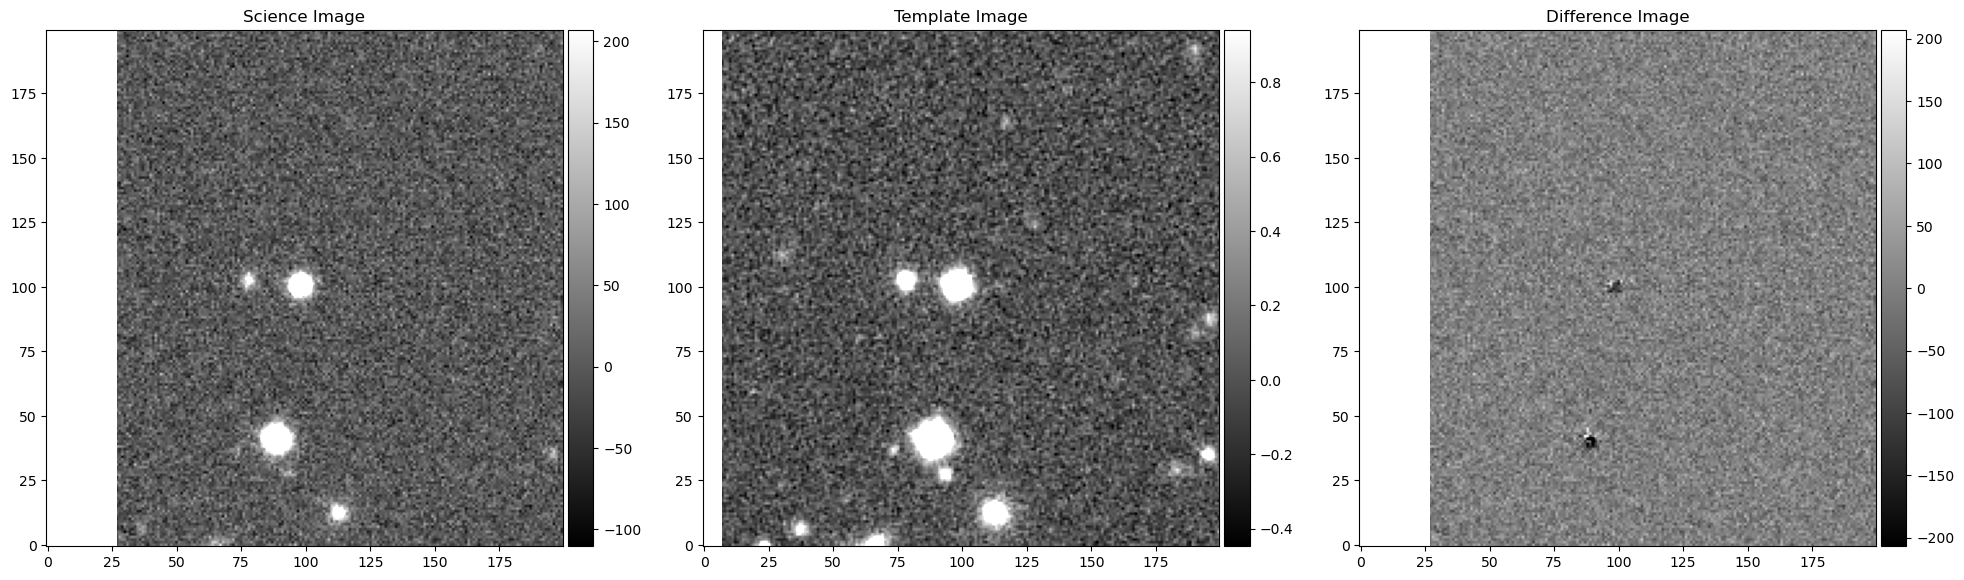

In [25]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.image.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.image.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Difference Image')

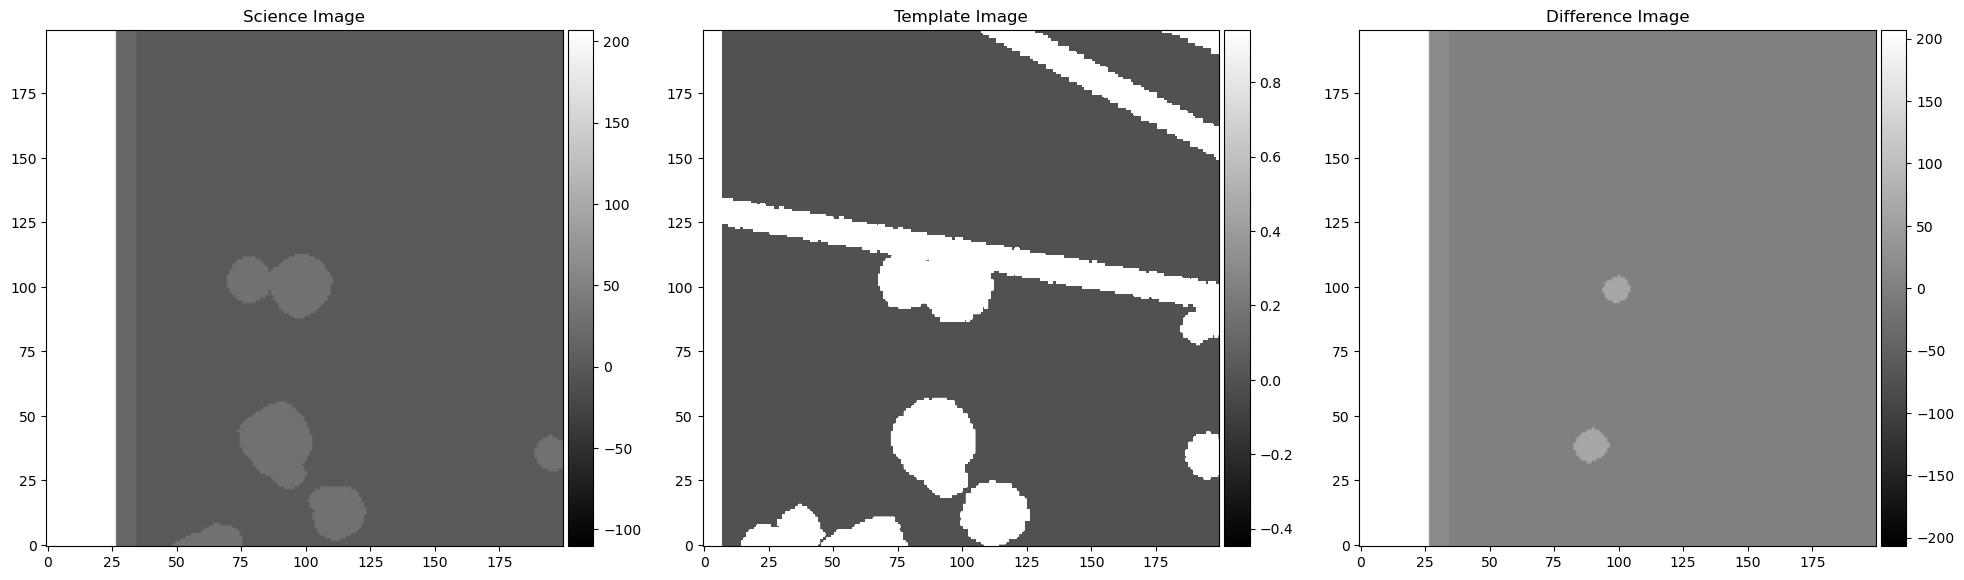

In [26]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.mask.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.mask.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.mask.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

In [27]:
print(np.unique(template_cutout.mask.array))
print(np.unique(difference_cutout.mask.array))
print(np.unique(science_cutout.mask.array))

mask_plane_dict = template_cutout.mask.getMaskPlaneDict().items()

# Invert the mask_plane_dict so we can look up bit positions
bit_to_flag = {v: k for k, v in mask_plane_dict}

# Function to explain mask value
def explain_mask_value(mask_value):
    explanations = []
    for bit_position in range(32):  # Assume 32-bit mask values, adjust if necessary
        if mask_value & (1 << bit_position):  # Check if the bit at bit_position is set
            flag = bit_to_flag.get(bit_position, f'Unknown flag at bit {bit_position}')
            explanations.append(flag)
    return explanations

# Print explanations for each unique mask value
for value in np.unique(template_cutout.mask.array):
    explanation = explain_mask_value(value)
    print(f"Mask value {value} has the following flags set: {explanation}")

[    0    32   256 18432 18464]
[  0   1  17  64 256]
[  0  16  32 256]
Mask value 0 has the following flags set: []
Mask value 32 has the following flags set: ['DETECTED']
Mask value 256 has the following flags set: ['NO_DATA']
Mask value 18432 has the following flags set: ['INEXACT_PSF', 'SENSOR_EDGE']
Mask value 18464 has the following flags set: ['DETECTED', 'INEXACT_PSF', 'SENSOR_EDGE']


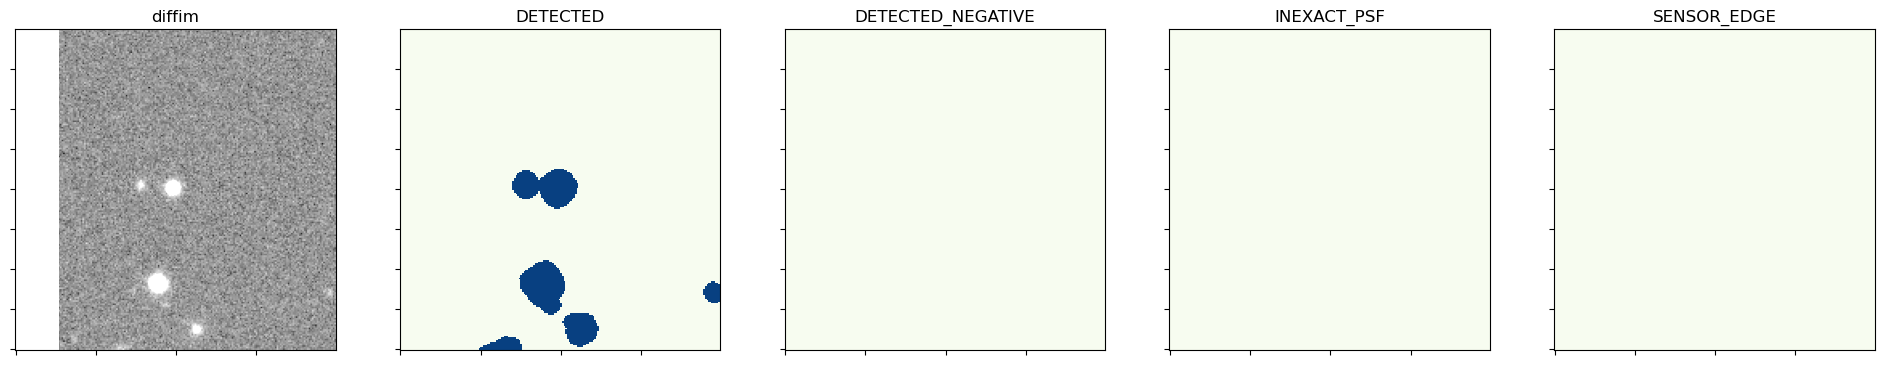

In [28]:
plotFlagImages(science_cutout)

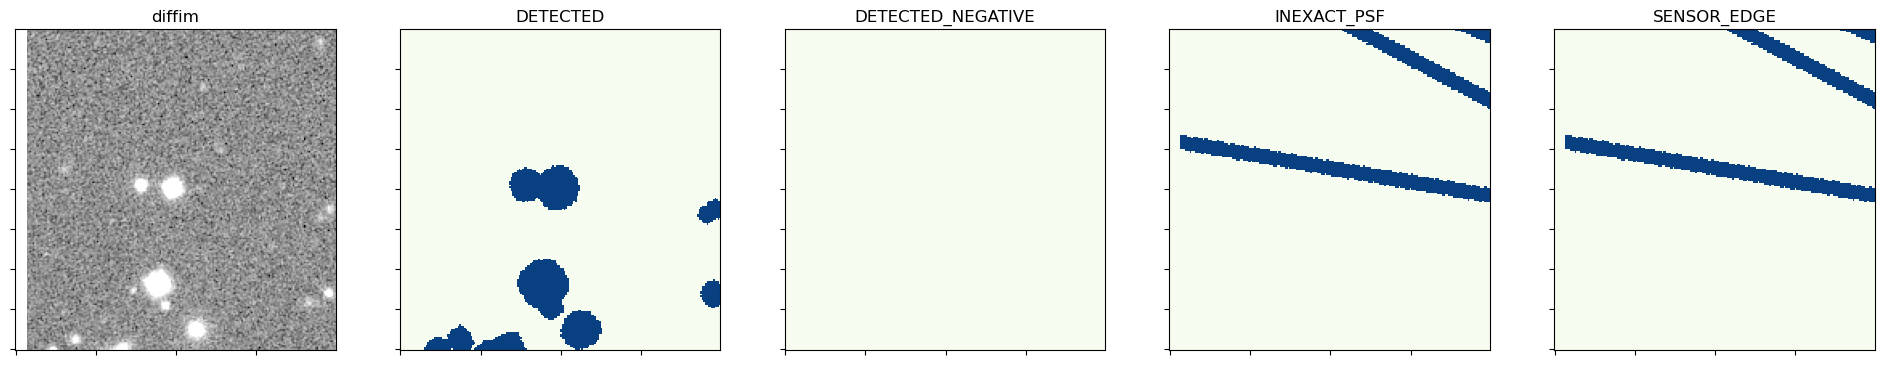

In [29]:
plotFlagImages(template_cutout)

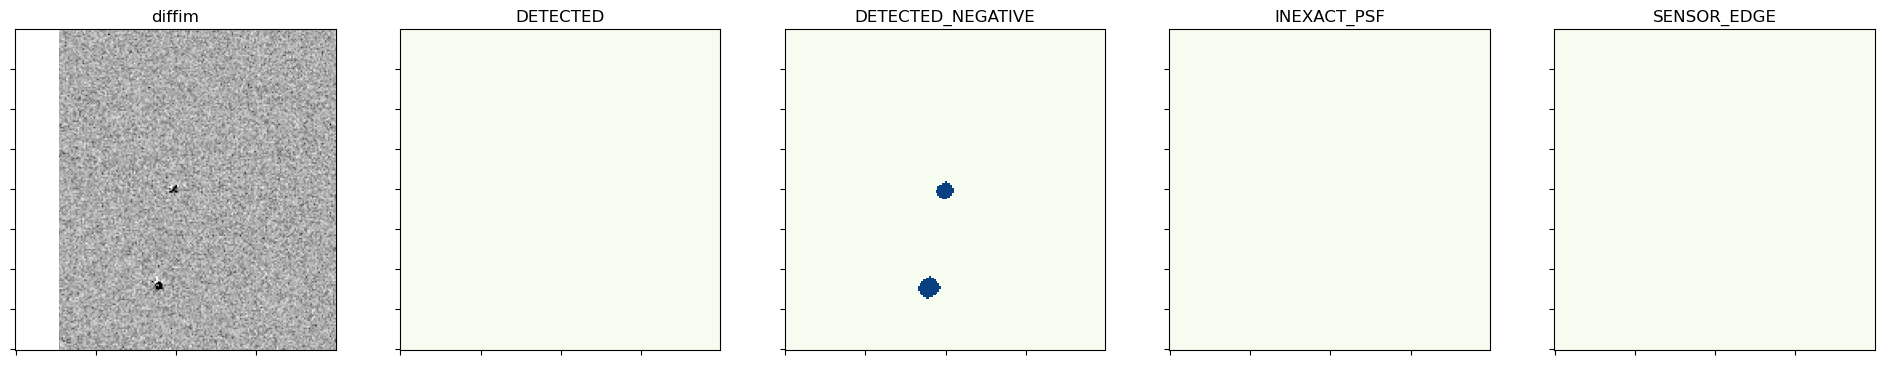

In [30]:
plotFlagImages(difference_cutout)

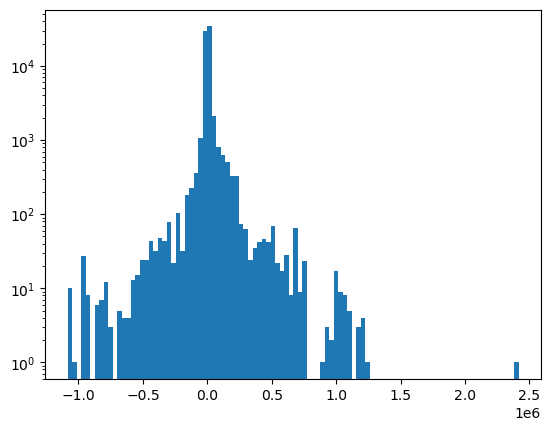

In [31]:
# plot a histogram of psfFluxes for all sources to see if there is something obvious
plt.hist(src4_field['psfFlux'].values, bins=100, log=True);

In [32]:
len(src4_field[src4_field['psfFlux'].values>0])

42574

In [33]:
len(src4_field[src4_field['psfFlux'].values<0])

29545

In [34]:
repo = 'embargo_new'
collection = 'u/rhl/tmp'
butler = dafButler.Butler(repo,collections=collection)
registry = butler.registry

# One in particular that has a "nice" ghost
exp = butler.get('postISRCCD', dataId={'instrument': 'LSSTComCam', 'detector': 8, 'exposure': 2024102400126})

# Purity completness as function of magnitude

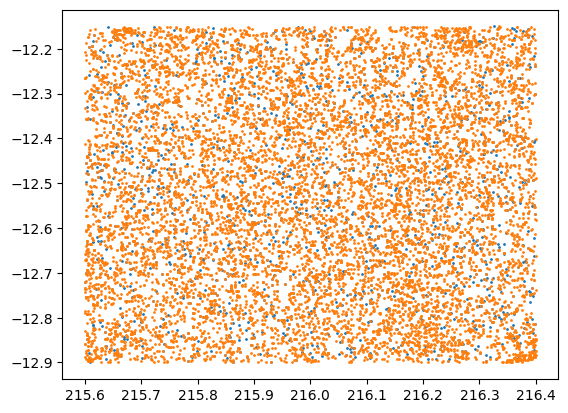

In [35]:
plt.scatter(tru_var_obj['ra'], tru_var_obj['dec'], s=1)
plt.scatter(obj4_3_field['ra'], obj4_3_field['dec'], s=1)

In [72]:
test_mjd = 60487.092593
mjd0 = 60400
mjd = src4_3_field[src4_3_field['diaObjectId'] == 3068394109505896673]['midpointMjdTai']
tru_var_obj['magnorm'] + tru_var_obj['mag_amplitude']*np.sin(2.*np.pi*(test_mjd - mjd0)/tru_var_obj['period'] + tru_var_obj['phase'])


3         24.244453
2419      26.767483
2423      21.612109
2424      20.195662
2437      20.974401
            ...    
174234    24.225816
174237    22.370758
174238    22.971470
174265    25.417582
174387    24.498203
Length: 1773, dtype: float64

In [78]:
# magnitude calculation

df_single_mag = flux_to_magnitude(df_single_flux)
df_single_mag

,id,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,galaxy_id,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,1009992351,5.406708e-08,0.000003,0.000010,0.000019,0.000020,9.767979e-06,NaN,30.820018,28.376387,27.054178,26.163163,25.762827,25.542855
1,1072182018,1.306984e-04,0.002023,0.002656,0.002628,0.001943,8.130870e-04,NaN,22.361675,21.424683,20.998924,20.829817,20.771951,20.742025
2,1072182088,1.186530e-07,0.000007,0.000021,0.000059,0.000068,3.588802e-05,NaN,29.966655,27.509618,26.236319,24.953641,24.407358,24.129994
3,1009994123,2.267574e-06,0.000096,0.000205,0.000249,0.000205,9.276596e-05,NaN,26.763448,24.735084,23.782157,23.387547,23.215225,23.098896
4,1009998348,6.683418e-08,0.000004,0.000012,0.000033,0.000038,2.021481e-05,NaN,30.589855,28.132818,26.859519,25.576841,25.030558,24.753193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10181479,NaN,7.746706e-08,0.000007,0.000009,0.000008,0.000006,2.428933e-06,6.082004e+09,30.429558,27.643787,27.152089,27.081093,27.091560,27.053828
10181480,NaN,3.677928e-07,0.000013,0.000016,0.000014,0.000010,4.007197e-06,6.082005e+09,28.738343,26.868565,26.523575,26.507838,26.455870,26.510265
10181481,NaN,9.761634e-08,0.000005,0.000008,0.000007,0.000005,2.451401e-06,6.082005e+09,30.178545,27.929100,27.304757,27.199744,27.153922,27.043832
10181482,NaN,1.358847e-08,0.000001,0.000002,0.000002,0.000002,8.264337e-07,6.082006e+09,32.319424,29.590694,28.803205,28.529388,28.421902,28.224347


In [80]:
tru_var_obj

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
3,star,1009994123,216.207569,-12.180939,0,24.234124,starSED/kurucz/km15_4500.fits_g00_4680.gz,3.1,0.274954,-0.34,-2.50,38.580002,0.060423,,None,True,0.991257,0.103657,3.916524
2419,star,1072181022,216.190249,-12.202527,0,26.385021,starSED/kurucz/km30_4250.fits_g00_4330.gz,3.1,0.273828,-1.50,-2.19,208.200000,0.038548,,None,True,2.133275,0.620653,3.572403
2423,star,1072180941,216.191984,-12.209090,0,21.491287,starSED/kurucz/km25_6000.fits_g30_6080.gz,3.1,0.273828,-2.67,-1.51,85.809998,0.050910,,None,True,6.915724,0.124658,3.876700
2424,star,250325369,216.162784,-12.201172,0,20.740699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.272701,-11.44,-3.78,6.960000,1.020000,,None,True,8.165801,0.879210,1.432904
2437,star,774753087,216.171834,-12.242497,0,20.432092,starSED/kurucz/km10_5250.fits_g15_5410.gz,3.1,0.273828,-0.25,-5.52,-2.620000,0.155239,,None,True,8.323236,0.613939,4.452022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174234,star,930634037,216.379745,-12.405843,0,24.057310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-0.48,-7.38,8.530000,0.851922,,None,True,0.140427,0.427471,5.435825
174237,star,1072184172,216.377521,-12.399553,0,22.384865,starSED/kurucz/km15_5000.fits_g05_5060.gz,3.1,0.282842,-0.75,-5.18,-110.080000,0.098628,,None,True,0.161654,0.105586,1.369566
174238,star,774762453,216.380578,-12.396774,0,22.344290,starSED/kurucz/km30_4000.fits_g05_4200.gz,3.1,0.282842,-1.46,-1.73,-24.010000,0.240215,,None,True,6.917946,0.675635,3.769819
174265,star,774761880,216.372721,-12.395497,0,26.200310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-8.97,-1.31,-1.410000,0.329155,,None,True,0.390458,0.790919,4.527125


In [142]:
# Select only the id and magnitude columns from df_single_mag
mag_columns = ['id', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y']
df_magnitudes = df_single_mag[mag_columns]

# Merge magnitudes into tru_var_obj based on the 'id' column
tru_var_obj_updated = tru_var_obj.merge(df_magnitudes, on='id', how='left')
all_obj_updated = all_obj.merge(df_magnitudes, on='id', how='left')

In [82]:
# tru_var_obj_updated now has the magnitudes
tru_var_obj_updated

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,...,is_variable,period,mag_amplitude,phase,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,star,1009994123,216.207569,-12.180939,0,24.234124,starSED/kurucz/km15_4500.fits_g00_4680.gz,3.1,0.274954,-0.34,...,True,0.991257,0.103657,3.916524,26.763448,24.735084,23.782157,23.387547,23.215225,23.098896
1,star,1072181022,216.190249,-12.202527,0,26.385021,starSED/kurucz/km30_4250.fits_g00_4330.gz,3.1,0.273828,-1.50,...,True,2.133275,0.620653,3.572403,29.164408,26.920844,25.715967,25.173869,24.923020,24.771954
2,star,1072180941,216.191984,-12.209090,0,21.491287,starSED/kurucz/km25_6000.fits_g30_6080.gz,3.1,0.273828,-2.67,...,True,6.915724,0.124658,3.876700,22.716171,21.900759,21.526343,21.376645,21.328492,21.308913
3,star,250325369,216.162784,-12.201172,0,20.740699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.272701,-11.44,...,True,8.165801,0.879210,1.432904,23.363934,20.932940,19.590980,18.787545,18.422780,18.220086
4,star,774753087,216.171834,-12.242497,0,20.432092,starSED/kurucz/km10_5250.fits_g15_5410.gz,3.1,0.273828,-0.25,...,True,8.323236,0.613939,4.452022,22.106820,20.860288,20.288331,20.062083,19.974408,19.917134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,star,930634037,216.379745,-12.405843,0,24.057310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-0.48,...,True,0.140427,0.427471,5.435825,26.442572,23.893259,22.647879,21.163003,20.554088,20.249425
1769,star,1072184172,216.377521,-12.399553,0,22.384865,starSED/kurucz/km15_5000.fits_g05_5060.gz,3.1,0.282842,-0.75,...,True,0.161654,0.105586,1.369566,24.344784,22.855527,22.145004,21.848621,21.722165,21.641350
1770,star,774762453,216.380578,-12.396774,0,22.344290,starSED/kurucz/km30_4000.fits_g05_4200.gz,3.1,0.282842,-1.46,...,True,6.917946,0.675635,3.769819,25.222193,22.896105,21.644607,21.076150,20.807658,20.642950
1771,star,774761880,216.372721,-12.395497,0,26.200310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-8.97,...,True,0.390458,0.790919,4.527125,28.585572,26.036259,24.790880,23.306003,22.697088,22.392425


In [102]:
# obj4_3_field should have fluxes, but it doesnt

# Step 1: Calculate mean flux for each diaObjectId in each band
mean_flux_per_object_band = src4_3_field.groupby(['diaObjectId', 'band'])['scienceFlux'].mean().unstack(fill_value=0)
mean_flux_per_object_band = mean_flux_per_object_band.rename(columns={
    'g': 'g_band_flux_mean', 
    'r': 'r_band_flux_mean', 
    'i': 'i_band_flux_mean'
}).reset_index()

# Step 2: Merge mean flux values into obj4_3_field
obj4_3_field_updated = obj4_3_field.merge(mean_flux_per_object_band, on='diaObjectId', how='left')

obj4_3_field_updated['g_band_mag'] = obj4_3_field_updated['g_band_flux_mean'].apply(create_mag)
obj4_3_field_updated['r_band_mag'] = obj4_3_field_updated['r_band_flux_mean'].apply(create_mag)
obj4_3_field_updated['i_band_mag'] = obj4_3_field_updated['i_band_flux_mean'].apply(create_mag)

obj4_3_field_updated.replace([np.inf, -np.inf], np.nan, inplace=True)

obj4_3_field_updated[['g_band_mag','r_band_mag', 'i_band_mag']]

,g_band_mag,r_band_mag,i_band_mag
0,NaN,19.450624,19.303627
1,18.464414,18.021051,17.600635
2,20.485682,NaN,19.735070
3,18.771737,18.018793,17.748668
4,16.368092,15.991813,15.859508
...,...,...,...
11171,NaN,23.518459,NaN
11172,NaN,23.890940,NaN
11173,NaN,21.236900,NaN
11174,NaN,23.696750,NaN


In [ ]:
all_obj

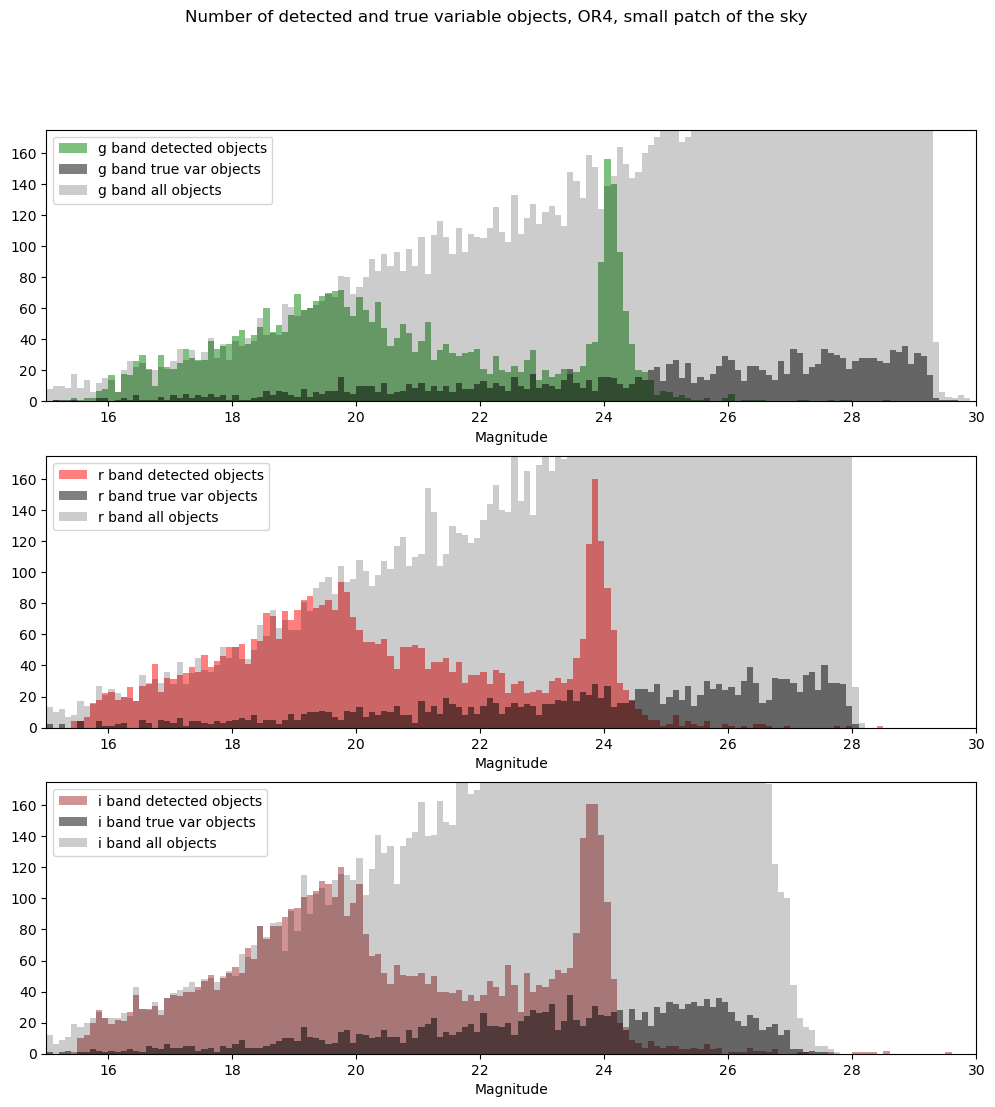

In [145]:
plt.figure(figsize=(12, 12))
plt.suptitle('Number of detected and true variable objects, OR4, small patch of the sky')

plt.subplot(3, 1, 1)
plt.hist(obj4_3_field_updated['g_band_mag'][~np.isnan(obj4_3_field_updated['g_band_mag'])], color='g', alpha=0.5, bins=np.arange(15,30,0.1), label='g band detected objects');
plt.hist(tru_var_obj_updated['mag_g'], color='black', alpha=0.5, bins=np.arange(15,30,0.1), label='g band true var objects');
plt.hist(all_obj_updated['mag_g'], color='black', alpha=0.2, bins=np.arange(15,30,0.1), label='g band all objects');
plt.xlim(15, 30)
plt.ylim(0, 175)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(3, 1, 2)
plt.hist(obj4_3_field_updated['r_band_mag'][~np.isnan(obj4_3_field_updated['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');
plt.hist(tru_var_obj_updated['mag_r'], color='black', alpha=0.5, bins=np.arange(15,30,0.1), label='r band true var objects');
plt.hist(all_obj_updated['mag_r'], color='black', alpha=0.2, bins=np.arange(15,30,0.1), label='r band all objects');
plt.xlim(15, 30)
plt.ylim(0, 175)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(3, 1, 3)
plt.hist(obj4_3_field_updated['i_band_mag'][~np.isnan(obj4_3_field_updated['i_band_mag'])], color='brown', alpha=0.5, bins=np.arange(15,30,0.1), label='i band detected objects');
plt.hist(tru_var_obj_updated['mag_i'], color='black', alpha=0.5, bins=np.arange(15,30,0.1), label='i band true var objects');
plt.hist(all_obj_updated['mag_i'], color='black', alpha=0.2, bins=np.arange(15,30,0.1), label='i band all objects');
plt.xlim(15, 30)
plt.ylim(0, 175)
plt.xlabel('Magnitude')
plt.legend();



In [64]:
# Step 1: Group and count observations in each band for each diaObjectId
band_counts = src4_3_field.groupby(['diaObjectId', 'band']).size().unstack(fill_value=0).reset_index()
band_counts = band_counts.rename(columns={'g': 'g_band_obs', 'r': 'r_band_obs', 'i': 'i_band_obs'})

# Step 2: Merge these counts into the obj4_3_field table
obj4_3_field = obj4_3_field.merge(band_counts, on='diaObjectId', how='left')

In [83]:
src4_3_field

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability,magnitude,magnitude_err
0,3068394109518479517,3068394109518479517,216.160285,-12.663203,NaN,NaN,60487.089310,-1076.299316,207.883987,-1006.854553,...,False,False,False,False,False,False,False,None,NaN,NaN
1,3068394110583832585,3068394109510091043,215.859358,-12.726199,NaN,NaN,60487.089779,-2070.754639,345.483368,85429.445312,...,False,False,False,False,False,False,False,None,19.070981,0.004173
2,3068394111686934659,3068394111686934659,215.838273,-12.166796,NaN,NaN,60487.090247,-1568.523804,288.526306,35507.328125,...,False,False,False,False,False,False,False,None,20.024205,0.007947
3,3068394112727122132,3068394112727122132,216.243631,-12.826803,NaN,NaN,60487.090715,-2029.264282,329.781342,53210.371094,...,False,False,False,False,False,False,False,None,19.585009,0.006071
4,3068394112748093492,3068394112748093492,215.748136,-12.527903,NaN,NaN,60487.090715,-1237.230957,252.831375,21714.544922,...,False,False,False,False,False,False,False,None,20.558123,0.011786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72154,3068394117030478062,3068394109522673688,215.773616,-12.659882,0.000008,0.000010,60487.092593,7787.665527,762.346252,495131.250000,...,False,False,False,False,False,False,False,None,17.163199,0.001583
72155,3068394117030478063,3068394109522673703,215.849753,-12.672358,0.000010,0.000009,60487.092593,3067.706787,218.062866,3110.255615,...,False,False,False,False,False,False,False,None,22.668010,0.071787
72156,3068394117030478064,3068394110579638332,215.924138,-12.684180,0.000021,0.000023,60487.092593,1107.472412,212.829620,1762.165405,...,False,False,False,False,False,False,False,None,23.284883,0.124625
72157,3068394117030478065,3068394109522673705,215.864918,-12.673718,NaN,NaN,60487.092593,-3149.211426,422.013245,144429.265625,...,False,False,False,False,False,False,False,None,18.500862,0.002999


In [65]:
obj4_3_field[['diaObjectId','g_scienceFluxMean', 'r_scienceFluxMean', 'i_scienceFluxMean', 'nDiaSources', 'g_band_obs', 'r_band_obs', 'i_band_obs']]

,diaObjectId,g_scienceFluxMean,r_scienceFluxMean,i_scienceFluxMean,nDiaSources,g_band_obs,r_band_obs,i_band_obs
0,3068394109505896606,NaN,6.022133e+04,NaN,5,0,1,4
1,3068394109505896641,NaN,2.015020e+05,NaN,20,6,9,5
2,3068394109505896643,23212.785156,NaN,NaN,3,1,0,2
3,3068394109505896646,NaN,2.210899e+05,NaN,16,3,8,5
4,3068394109505896647,NaN,1.456220e+06,NaN,26,9,10,7
...,...,...,...,...,...,...,...,...
11171,3068394172890218555,NaN,1.421074e+03,NaN,1,0,1,0
11172,3068394172890218582,NaN,1.008379e+03,NaN,1,0,1,0
11173,3068394172890218584,NaN,1.162091e+04,NaN,1,0,1,0
11174,3068394172890218587,NaN,1.205869e+03,NaN,1,0,1,0


In [56]:
np.sum(np.isnan(obj4_3_field['i_scienceFluxMean']))

7636

In [49]:
src4_3_field[src4_3_field['diaObjectId']==3068394109505896606][['band']]

,band
25,i
18388,i
19574,i
34474,i
54435,r


In [59]:
obj4_3_field[~np.isnan(obj4_3_field['i_scienceFluxMean'])][['diaObjectId','g_scienceFluxMean', 'r_scienceFluxMean', 'i_scienceFluxMean', 'nDiaSources']]

,diaObjectId,g_scienceFluxMean,r_scienceFluxMean,i_scienceFluxMean,nDiaSources
145196,3068394109505896648,NaN,NaN,33360.265625,1
145199,3068394109505896651,NaN,NaN,12684.598633,1
145219,3068394109505896673,NaN,NaN,4666.782715,7
145224,3068394109505896678,NaN,NaN,36221.406250,1
145225,3068394109505896679,NaN,NaN,34674.437500,1
...,...,...,...,...,...
154558,3068394129936351386,NaN,NaN,-1100.740479,1
154559,3068394129936351387,NaN,NaN,1138.470703,1
154575,3068394129940545596,NaN,NaN,1211.670410,1
154618,3068394129940545787,NaN,NaN,-1246.948853,1


In [43]:
obj4_3_field.columns

Index(['diaObjectId', 'validityStart', 'validityEnd', 'ra', 'raErr', 'dec',
       'decErr', 'ra_dec_Cov', 'radecMjdTai', 'pmRa',
       ...
       'y_psfFluxMin', 'y_psfFluxMax', 'y_psfFluxStetsonJ',
       'y_psfFluxLinearSlope', 'y_psfFluxLinearIntercept', 'y_psfFluxMaxSlope',
       'y_psfFluxErrMean', 'lastNonForcedSource', 'nDiaSources', 'matched'],
      dtype='object', length=191)

In [60]:
src4_field[src4_field['diaObjectId'] == 3068394109505896673][['scienceFlux','band']]

,scienceFlux,band
41,4984.385254,i
4903,4408.356445,i
8143,4582.326172,i
18207,4992.570312,i
19581,4914.099609,i
34478,4307.532715,i
71781,4570.305664,i


# Machine learning

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance


flag_columns = ['centroid_flag','apFlux_flag','trail_flag_edge',
                'forced_PsfFlux_flag','shape_flag','pixelFlags']

# Combine features and target to drop rows with NaN values
df_clean = src4_3_field_bright[flag_columns + ['matched']].dropna()

# Define the features (flag columns) and the target (matched column) after NaN removal
X = df_clean[flag_columns]  # Feature matrix (flags)
y = df_clean['matched']  # Target variable (matched)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Determine feature importance
importance = clf.feature_importances_

# Display feature importance
feature_importance = pd.DataFrame({'Feature': flag_columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Accuracy: 0.7670003451846737

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87     13332
         1.0       0.00      0.00      0.00      4050

    accuracy                           0.77     17382
   macro avg       0.38      0.50      0.43     17382
weighted avg       0.59      0.77      0.67     17382


Feature Importance:
               Feature  Importance
0        centroid_flag    0.632381
4           shape_flag    0.363100
3  forced_PsfFlux_flag    0.004517
1          apFlux_flag    0.000002
2      trail_flag_edge    0.000000
5           pixelFlags    0.000000


In [25]:
src4_3_field_bright[flag_columns]

,centroid_flag,apFlux_flag,trail_flag_edge,forced_PsfFlux_flag,shape_flag,pixelFlags
0,True,True,False,True,True,False
1,True,True,False,True,True,False
2,True,True,False,True,True,False
3,True,True,False,True,True,False
4,True,True,False,True,True,False
...,...,...,...,...,...,...
57942,False,False,False,False,False,False
57943,False,False,False,False,False,False
57944,False,False,False,False,False,False
57945,False,False,False,False,False,False


In [28]:
np.sum(y_pred)

0.0

In [27]:
X_test

,centroid_flag,apFlux_flag,trail_flag_edge,forced_PsfFlux_flag,shape_flag,pixelFlags
19184,False,False,False,False,False,False
20827,False,False,False,False,False,False
50480,False,False,False,False,False,False
10128,True,True,False,True,True,False
46804,False,False,False,False,False,False
...,...,...,...,...,...,...
26170,True,True,False,True,True,False
18567,True,True,False,True,True,False
20476,False,False,False,False,False,False
6798,False,False,False,False,False,False
